In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## 数据准备

In [22]:
df1=pd.read_csv('data/stock_profit.csv')[['code','npMargin','netProfit','MBRevenue','epsTTM','totalShare','liqaShare']]
df2=pd.read_csv('data/stock_growth.csv')[['code','YOYEquity','YOYEPSBasic','YOYNI']]
df3=pd.read_csv('data/stock_balance.csv')[['code','liabilityToAsset','currentRatio','assetToEquity','YOYLiability']]
df4=pd.read_csv('data/stock_dupont.csv')[['code','dupontAssetTurn']]
df5=pd.read_csv('data/stock_industry.csv', encoding='GBK')[['code','code_name','industry']]
df6=pd.read_csv('data/stock_k_data(2024_01_02).csv')[['code','open','volume']]

In [23]:
df=pd.merge(df1,df2,on='code')
df=pd.merge(df,df3,on='code')
df=pd.merge(df,df4,on='code')
df=pd.merge(df,df5,on='code')
df=pd.merge(df,df6,on='code')
df=df[df['industry']=='化工']
df=df.dropna().reset_index(drop=True)
print(df.shape,df.columns)
df.head(2)
# df.to_csv('./data/merged.csv')

(427, 19) Index(['code', 'npMargin', 'netProfit', 'MBRevenue', 'epsTTM', 'totalShare',
       'liqaShare', 'YOYEquity', 'YOYEPSBasic', 'YOYNI', 'liabilityToAsset',
       'currentRatio', 'assetToEquity', 'YOYLiability', 'dupontAssetTurn',
       'code_name', 'industry', 'open', 'volume'],
      dtype='object')


,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,liabilityToAsset,currentRatio,assetToEquity,YOYLiability,dupontAssetTurn,code_name,industry,open,volume
0,sh.600028,0.021806,7.004600e+10,3.212215e+12,0.506606,1.193493e+11,9.497197e+10,0.021970,-0.090090,-0.085728,0.526981,0.825923,2.114081,0.056750,1.616081,中国石化,化工,5.58,146220062.0
1,sh.600063,0.040604,3.354961e+08,7.750978e+09,0.158248,2.159249e+09,1.925895e+09,0.038604,-0.764706,-0.753425,0.426727,0.963361,1.744371,0.097565,0.604484,皖维高新,化工,4.33,10052054.0


In [24]:
columns=['npMargin', 'netProfit', 'epsTTM', 'totalShare','liqaShare','YOYEquity','MBRevenue','YOYNI',
       'YOYEPSBasic', 'liabilityToAsset', 'currentRatio', 'assetToEquity',
       'YOYLiability', 'dupontAssetTurn']
X = df[columns]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [25]:
def remove_outliers(series):
    mean = series.mean()
    std = series.std()
    threshold = 3  # 可调整阈值
    return abs(series - mean) <= threshold * std
outliers=X[-X.apply(remove_outliers).all(axis=1)]
X=X[X.apply(remove_outliers).all(axis=1)]

## 因子分析

In [26]:
n_factors = 5  # 指定要提取的因子数量，可以根据需要调整
rotation_method = 'varimax'  # 指定旋转方法，可以根据需要调整
fa = FactorAnalyzer(n_factors, rotation=rotation_method)
fa.fit(X)
loadings = fa.loadings_
fa.get_factor_variance()[2]

array([0.19547811, 0.36023961, 0.51328235, 0.64280093, 0.67737655])

In [27]:
fa.loadings_

array([[ 0.0782272 , -0.23669562,  0.75609833,  0.12781317, -0.12906419],
       [ 0.54317622,  0.03973843,  0.53881657,  0.01102279,  0.02253876],
       [ 0.03175109, -0.09569674,  0.8956531 ,  0.10278284,  0.0945303 ],
       [ 0.99225626,  0.09466832,  0.01461905,  0.0054206 ,  0.0045178 ],
       [ 0.99470744,  0.08897097,  0.0149076 ,  0.00667614, -0.01728538],
       [-0.01918803, -0.10819113,  0.56238942,  0.21763496, -0.02484108],
       [ 0.64011141,  0.23924313,  0.05144035,  0.03223809,  0.30095568],
       [ 0.02385717, -0.01547699,  0.20295527,  0.95693471,  0.05407443],
       [ 0.01275163, -0.02174177,  0.18471411,  0.90543696,  0.02284331],
       [ 0.07844777,  1.00186052, -0.13165352, -0.01574422,  0.05576936],
       [-0.15254594, -0.68293041,  0.09441713,  0.02730337,  0.07256981],
       [ 0.11912807,  0.79323669, -0.18741105, -0.0103212 ,  0.12763425],
       [-0.07774963,  0.12126994,  0.10982408, -0.01409209, -0.28394563],
       [ 0.00260195,  0.19828532,  0.1

In [28]:
columns

['npMargin',
 'netProfit',
 'epsTTM',
 'totalShare',
 'liqaShare',
 'YOYEquity',
 'MBRevenue',
 'YOYNI',
 'YOYEPSBasic',
 'liabilityToAsset',
 'currentRatio',
 'assetToEquity',
 'YOYLiability',
 'dupontAssetTurn']

In [29]:
factor_scores=fa.transform(X)
X_1=pd.DataFrame(data=factor_scores, columns=[f'Factor{i+1}' for i in range(n_factors)])
X_1

,Factor1,Factor2,Factor3,Factor4,Factor5
0,0.908156,0.041513,-0.240952,-0.184170,-0.367321
1,0.614437,0.816625,-1.370552,-0.529898,-0.338208
2,-0.292026,1.148577,-0.464793,-0.216445,-0.369156
3,0.639031,1.368264,3.202747,-0.765035,2.235295
4,0.149609,0.770563,1.222274,-0.526261,0.306004
...,...,...,...,...,...
365,-0.440118,-1.602977,0.558425,-0.099164,0.323105
366,-0.603376,-0.421839,0.706610,-0.005845,-0.382732
367,-0.614880,-0.336180,0.055212,0.151638,-0.157599
368,-0.070510,-0.626505,-0.159071,-0.179686,2.383849


## Kmeans 聚类

100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Text(0.5, 1.0, 'Silhouette score vs Number of clusters')

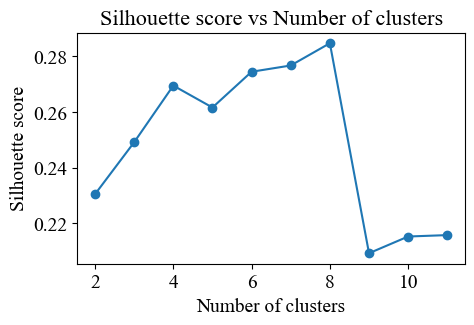

In [30]:
silhouette_avg = []
for i in tqdm(range(10)):
    kmeans = KMeans(n_clusters=i+2,n_init=100)
    kmeans.fit(X_1)
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X_1, labels))

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(5,3))
plt.plot(range(2,12),silhouette_avg,marker='o')
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('Silhouette score',fontsize=14)
plt.title('Silhouette score vs Number of clusters', fontsize=16)

In [34]:
kmeans = KMeans(n_clusters=4, n_init=300, random_state=42)
kmeans.fit(X_1)
labels = kmeans.labels_
silhouette_score(X_1, labels)

0.26914064469472526

In [35]:
kmeans.cluster_centers_

array([[-0.16394311, -0.93102852,  0.03986959,  0.06999955,  0.08084916],
       [-0.15351625,  0.88031157,  0.29093446,  0.24393503, -0.04726715],
       [ 4.57659818, -0.04048665,  0.44616079, -0.14129781, -0.16424582],
       [ 0.01810127,  0.58343352, -1.47681139, -1.25072915, -0.11958108]])

d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fu

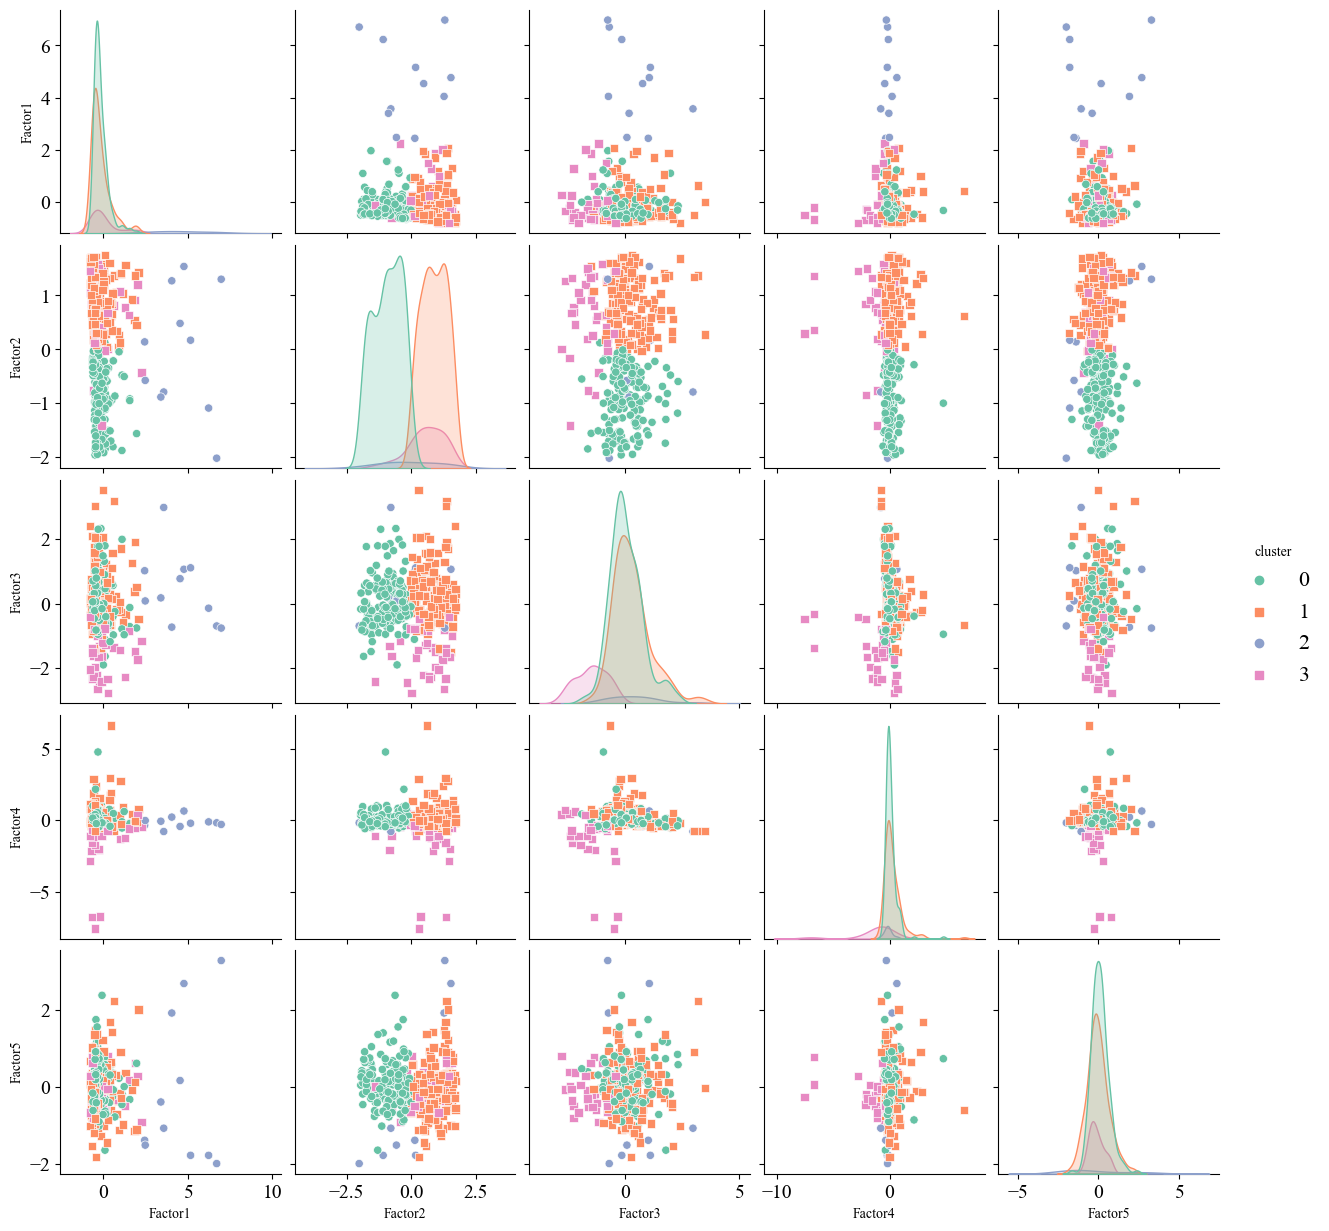

In [41]:
X_vis=X_1.copy()
X_vis['cluster']=labels




# 现在调用sns.pairplot
sns.pairplot(X_vis, diag_kind='kde', hue='cluster', palette='Set2', diag_kws=dict(shade=True), markers=['o', 's'])
# 设置字体大小
# plt.title('Pairplot of the K-means clusters', fontsize=20)
plt.rc('axes', labelsize=25)    # 设置坐标轴标签的字体大小
plt.rc('xtick', labelsize=14)   # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=14)   # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=16)   # 设置图例的字体大小
plt.show()


In [13]:
pd.Series(labels).value_counts()

2    168
1    153
0     38
3     11
dtype: int64

In [44]:
df_merged=pd.merge(df, X_vis, left_index=True, right_index=True,how='inner')
df_merged.reset_index(drop=True,inplace=True)
df_merged.head(2)

,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,...,code_name,industry,open,volume,Factor1,Factor2,Factor3,Factor4,Factor5,cluster
0,sh.600028,0.021806,7.004600e+10,3.212215e+12,0.506606,1.193493e+11,9.497197e+10,0.021970,-0.090090,-0.085728,...,中国石化,化工,5.58,146220062.0,0.908156,0.041513,-0.240952,-0.184170,-0.367321,1
1,sh.600063,0.040604,3.354961e+08,7.750978e+09,0.158248,2.159249e+09,1.925895e+09,0.038604,-0.764706,-0.753425,...,皖维高新,化工,4.33,10052054.0,0.614437,0.816625,-1.370552,-0.529898,-0.338208,3


## 多元线性回归

In [46]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设df_merged是一个包含回归特征和目标变量的DataFrame
X = df_merged[columns]
y = df_merged['open']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并拟合岭回归模型
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# 进行预测
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# 评估模型
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


Train MSE: 115.28207533862988
Test MSE: 101.79732548824198


d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.16358e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [47]:
from sklearn.linear_model import RidgeCV

# 使用交叉验证选择最佳alpha
alphas = [0.1, 1.0, 10.0, 100.0,200,300,400,500]
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# 输出最佳alpha
print(f'Best alpha: {ridge_cv.alpha_}')
y_pred_cv = ridge_cv.predict(X_test)
test_mse_cv = mean_squared_error(y_test, y_pred_cv)
print(f'Test MSE with RidgeCV: {test_mse_cv}')


Best alpha: 100.0
Test MSE with RidgeCV: 121.88124499153312


d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.64492e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.56313e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.85893e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.03169e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:21

In [48]:
from sklearn.linear_model import Ridge

X = df_merged[columns]
y = df_merged['open']
ridge = Ridge(alpha=300.0)
ridge.fit(X, y)
y_pred = ridge.predict(X)

d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.3868e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


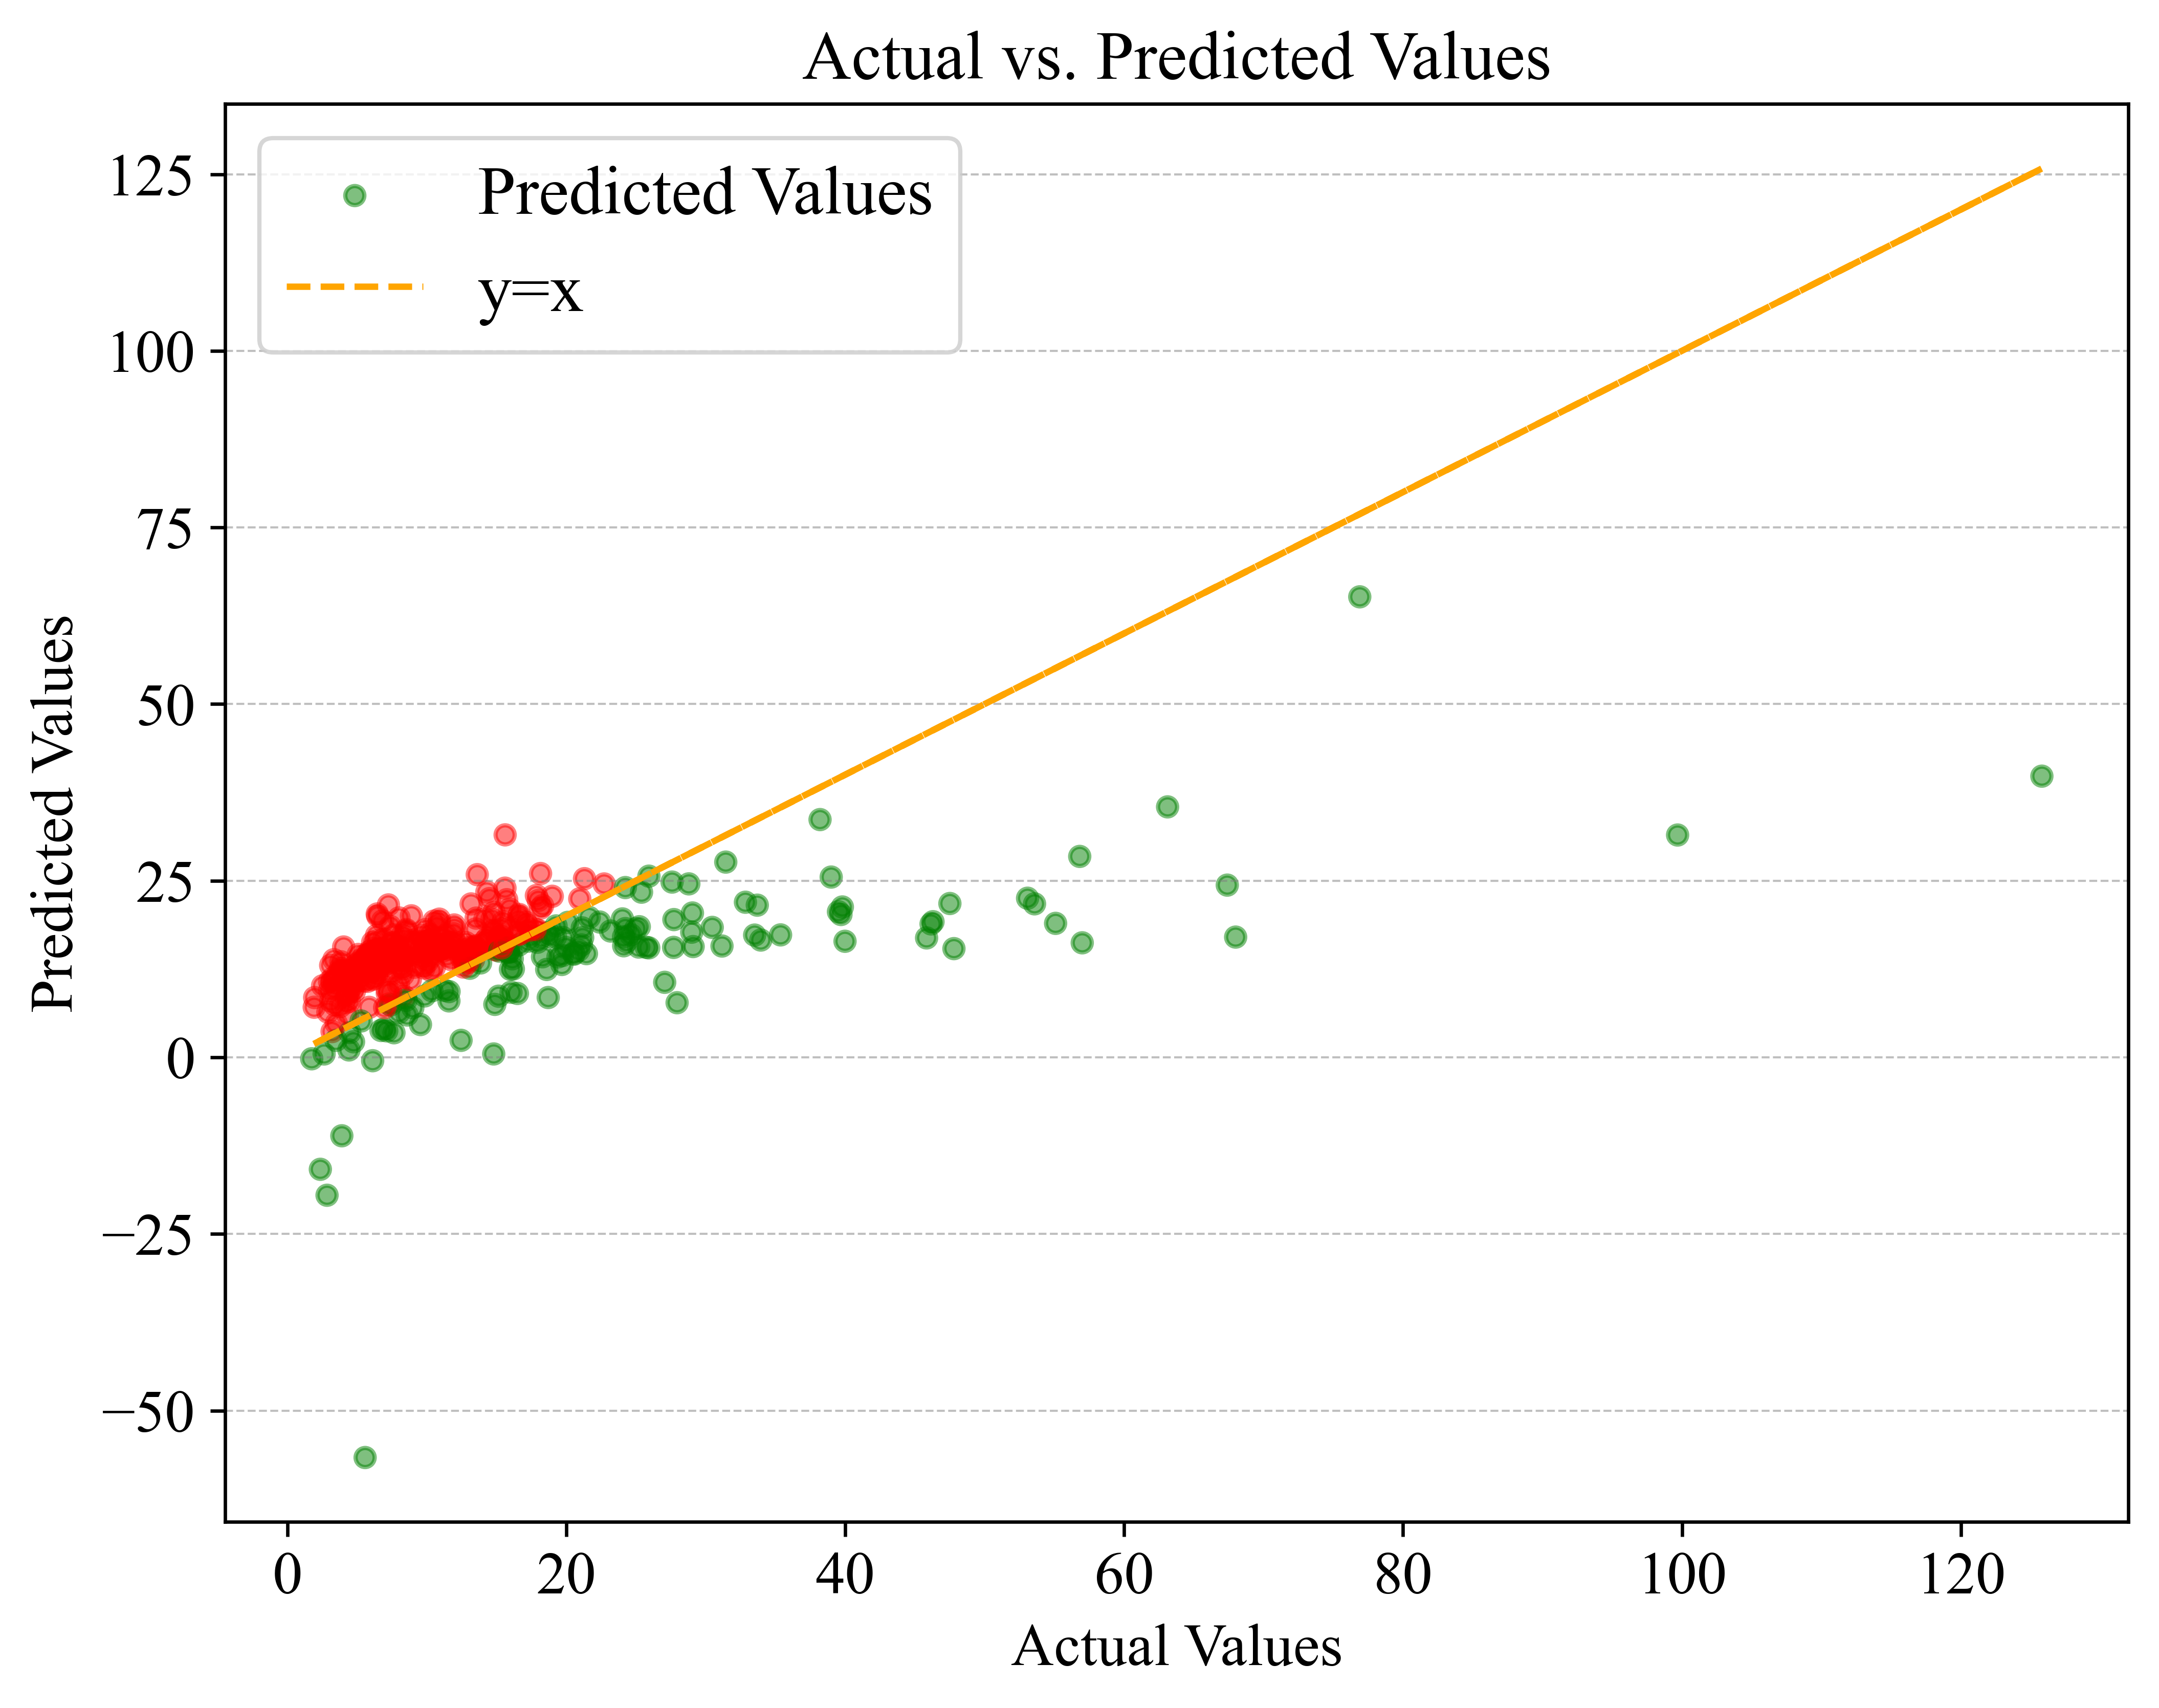

In [79]:
y_pred = ridge_cv.predict(X)
plt.figure(figsize=(8,6),dpi=600)
plt.scatter(df_merged['open'], y_pred, label='Predicted Values', s=20, alpha=0.5, color=['red' if y_pred[i] > df_merged['open'][i] else 'green' for i in range(len(y_pred))])
plt.plot(df_merged['open'], df_merged['open'], color='orange', linestyle='--', label='y=x')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted Values', fontsize=16)
plt.legend()
plt.show()


## 定义潜力股:  
1. 股票的预测价格高于实际价格 
2. 股票的收益整体是正的  
排名：股票收益率* residual

In [80]:
df_merged['predicted_open']=y_pred
df_merged['residual']=df_merged['predicted_open']-df_merged['open']
stock_candidate=df_merged[(df_merged['residual']>0)&(df_merged['epsTTM']>0)]
stock_candidate['ranking']=stock_candidate['residual']*stock_candidate['epsTTM']
stock_candidate=stock_candidate.sort_values(by='ranking',ascending=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24468\849425433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_candidate['ranking']=stock_candidate['residual']*stock_candidate['epsTTM']


In [81]:
stock_candidate['code_name']

4       云天化
55     三角轮胎
249    同德化工
191    双环科技
198    山东海化
       ... 
174    吉林化纤
366    星源材质
263    宝莫股份
127    美邦股份
91     艾艾精工
Name: code_name, Length: 197, dtype: object

In [82]:
## Compare the result to the tempory stock data

In [83]:
df_ref=pd.read_csv('data/stock_k_data(2024_04_01).csv')[['code','open']]
df_ref=pd.merge(df_merged[['code','open','code_name']],df_ref,on='code',how='inner')
print(df_ref.shape,df_ref.columns)
df_ref.head(2)

(370, 4) Index(['code', 'open_x', 'code_name', 'open_y'], dtype='object')


,code,open_x,code_name,open_y
0,sh.600028,5.58,中国石化,6.39
1,sh.600063,4.33,皖维高新,3.92


In [84]:
mean=(df_ref['open_y']-df_ref['open_x']).mean()
mean

-1.8492162162162162

In [85]:
# df_ref[df_ref['code'] in stock_candidate['code'][:10]]
top_df=df_ref[df_ref['code'].isin(stock_candidate['code'][0:10])]
(top_df['open_y']-top_df['open_x']).mean()

0.15800000000000028

In [86]:
top_df

,code,open_x,code_name,open_y
4,sh.600096,15.62,云天化,18.85
21,sh.600346,13.18,恒力石化,14.06
55,sh.601163,14.31,三角轮胎,16.28
84,sh.603299,8.53,苏盐井神,8.85
93,sh.603599,14.50,广信股份,14.62
98,sh.603639,15.73,海利尔,14.75
191,sz.000707,8.01,双环科技,7.01
198,sz.000822,6.84,山东海化,6.64
249,sz.002360,7.25,同德化工,6.25
310,sz.002986,15.61,宇新股份,13.85
